# Projeto Matemática Computacional (COC351)

In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact,interactive,interact_manual
from skimage import data, img_as_float
from IPython.display import display, clear_output

Dicionário de images (skimage)

In [2]:
gray_images = {
        "camera":data.camera(),
        "coin": data.coins(),
        "clock":data.clock()
}

In [3]:
color_images = {
    "cat":img_as_float(data.chelsea()),
    "astro":img_as_float(data.astronaut()),
    "coffee":img_as_float(data.coffee())
}

Classe Matrix

In [4]:
class Matrix(list):

    def __matmul__(self, B):
        A = self

        N = len(A)
        M = len(B[0])
        P = len(B)

        result = []

        for i in range(N):
            row = [0]*M
            result.append(row)

        for i in range(N):
          for j in range(M):
            for k in range(P):
                result[i][j] += A[i][k]*B[k][j]

        return result

#Funções

In [5]:
def reduce_image(image: list) -> list:

  """
    Function to reduce image size, by erasing odd rows and columns
  """

  image = np.array(image)

  odd_col = np.delete(image, list(range(1, image.shape[0], 2)), axis=0)
  all_odd = np.delete(odd_col, list(range(1, image.shape[1], 2)), axis=1)

  return all_odd

In [6]:
def reduced_svd(image: list, rank: int) -> list:

  """
    Function to calculate the SVD approximation of a matrix
  """

  U, sigma, V = svd(image, full_matrices=False)
  matrix_reconst = U[:,:rank]@(np.diag(sigma[:rank]))@V[:rank,:]
  return matrix_reconst, sigma

In [7]:
def plot_evalues(sigma):

    plt.figure(1)
    plt.semilogy(np.diag(sigma))
    plt.title('Valores singulares')
    plt.show(block=False)


In [8]:
def plot_sumevalues(sigma):

    plt.plot(np.cumsum(np.diag(sigma))/np.sum(np.diag(sigma)))
    plt.title('Soma cumulativa dos valores singulares')
    plt.show(block=False)

In [9]:
def zero_matrix_2D(h: int, w: int) -> list:

    matrix = [[0 for col in range(w)] for row in range(h)]

    return np.array(matrix)

def zero_matrix_3D(h: int, w: int, t: int) -> list:

    matrix = [[[0 for col in range(t)] for col in range(w)] for row in range(h)]

    return np.array(matrix)

Interpolação bilinear

In [10]:
def interpolate_bilinear_2D(image, zoom = 1):

    #Interpolation formula
    q = lambda a, b, sup, inf, x: a*(sup-x)+b*(x-inf)

    #Create new zero filled matrix for output values
    h, w = image.shape
    resized = zero_matrix_2D(int(h*zoom), int(w*zoom))

    for i in range(int(h*zoom)):
            for j in range(int(w*zoom)):

                #Map the coordinates
                x, y = i*(1/zoom), j*(1/zoom)

                #Calculate coordinates for adjancent pixels
                X = [math.floor(x), min(h-1, math.ceil(x))]
                Y = [math.floor(y), min(w-1, math.ceil(y))]

                #Check for overlapping pixels
                if (X[0] == X[1]) and (Y[0] == Y[1]):

                    qf = image[int(x), int(y)]

                elif (X[0] == X[1]):

                    q1 = image[int(x), int(Y[0])]
                    q2 = image[int(x), int(Y[1])]
                    qf = q(q1, q2, Y[1], Y[0], y)

                elif (Y[0] == Y[1]):

                    q1 = image[int(X[0]), int(y)]
                    q2 = image[int(X[1]), int(y)]
                    qf = q(q1, q2, X[1], X[0], x)

                else:

                    #Vector with values from adjacent pixels
                    V = [
                        image[X[0], Y[0]],
                        image[X[1], Y[0]],
                        image[X[0], Y[1]],
                        image[X[1], Y[1]]
                        ]

                    q1, q2 = q(V[0], V[1], X[1], X[0], x), q(V[2], V[3], X[1], X[0], x)
                    qf = q(q1, q2, Y[1], Y[0], y)

                resized[i, j] = qf

    return resized

In [11]:
def interpolate_bilinear_3D(image, zoom = 1):

    #Interpolation formula
    q = lambda a, b, sup, inf, x: a*(sup-x)+b*(x-inf)

    #Create new zero filled matrix for output values
    h, w, t = image.shape
    resized = np.zeros((int(h*zoom), int(w*zoom), t))

    for i in range(int(h*zoom)):
        for j in range(int(w*zoom)):

                #Map the coordinates
                x, y = i*(1/zoom), j*(1/zoom)

                #Calculate coordinates for adjancent pixels
                X = [math.floor(x), min(h-1, math.ceil(x))]
                Y = [math.floor(y), min(w-1, math.ceil(y))]

                #Check for overlapping pixels
                if (X[0] == X[1]) and (Y[0] == Y[1]):

                    qf = image[int(x), int(y), :]

                elif (X[0] == X[1]):

                    q1 = image[int(x), int(Y[0]), :]
                    q2 = image[int(x), int(Y[1]), :]
                    qf = q(q1, q2, Y[1], Y[0], y)

                elif (Y[0] == Y[1]):

                    q1 = image[int(X[0]), int(y), :]
                    q2 = image[int(X[1]), int(y), :]
                    qf = q(q1, q2, X[1], X[0], x)

                else:

                    #Vector with values from adjacent pixels
                    V = [
                        image[X[0], Y[0], :],
                        image[X[1], Y[0], :],
                        image[X[0], Y[1], :],
                        image[X[1], Y[1], :]
                        ]

                    q1, q2 = q(V[0], V[1], X[1], X[0], x), q(V[2], V[3], X[1], X[0], x)
                    qf = q(q1, q2, Y[1], Y[0], y)

                resized[i, j, :] = qf

    return resized

Interpolação Bicúbica

In [12]:
def padding_2D(img: list):

    H, W = img.shape
    r_image = zero_matrix_2D(H+4, W+4)
    r_image[2:H+2, 2:W+2] = img

    # Pad the first/last two col and row
    r_image[2:H+2, 0:2] = img[:, 0:1]
    r_image[H+2:H+4, 2:W+2] = img[H-1:H, :]
    r_image[2:H+2, W+2:W+4] = img[:, W-1:W]
    r_image[0:2, 2:W+2] = img[0:1, :]

    # Pad the missing points
    r_image[0:2, 0:2] = img[0, 0]
    r_image[H+2:H+4, 0:2] = img[H-1, 0]
    r_image[H+2:H+4, W+2:W+4] = img[H-1, W-1]
    r_image[0:2, W+2:W+4] = img[0, W-1]

    return r_image

def padding_3D(image: list) -> list:

    h, w, t = image.shape
    r_image = np.zeros((h+4, w+4, t))
    r_image[2:h+2, 2:w+2, :t] = image

    # Image side filling
    r_image[2:h+2, 0:2, :t] = image[:,0:1,:t]
    r_image[h+2:h+4, 2:w+2, :] = image[h-1:h,:,:]
    r_image[2:h+2, w+2:w+4, :] = image[:,w-1:w,:]
    r_image[0:2, 2:w+2, :t] = image[0:1,:,:t]

    # Image corner filling
    r_image[0:2, 0:2, :t] = image[0,0,:t]
    r_image[h+2:h+4, 0:2, :t] = image[h-1,0,:t]
    r_image[h+2:h+4, w+2:w+4, :t] = image[h-1,w-1,:t]
    r_image[0:2, w+2:w+4, :t] = image[0,w-1,:t]

    return r_image

In [13]:
def kernel_1(x: float, a: float = -0.5) -> float:
    """
        Kernel (Wikipedia)
        W(x)={
                (a+2)|x|³ - (a+3)|x|² + 1, |x| <=1
                a|x|³ - 5a|x|² + 8a|x| - 4a, 1< |x| <2
                0, c.c
        }
    """
    x = abs(x)

    if 0 <= x <= 1:
        return (a + 2) * (x ** 3) - (a + 3) * (x ** 2) + 1
    elif 1 < x <= 2:
        return a * (x ** 3) - (5 * a) * (x ** 2) + (8 * a) * x - 4 * a
    return 0

In [14]:
def kernel_2(x: float) -> float:
    """
        Kernel
        W(x)={
                (4/3)|x|³ - (7/3)|x|² + 1, |x| <=1
                (-7/12)|x|³ + 3|x|² - (59/12)|x| + 5/2, 1< |x| <2
                (1/12)|x|³ - (2/3)|x|² + (7/4)|x| - 3/2, 2< |x| <3
                0, c.c
        }
    """
    x = abs(x)

    if 0 <= x <= 1:
        return (4/3) * (x ** 3) - (7/3) * (x ** 2) + 1
    elif 1 < x <= 2:
        return (-7/12) * (x ** 3) + 3 * (x ** 2) - (59/12) * x + 5/2
    elif 2 < x <= 3:
        return (1/12) * (x**3) - (2/3) * (x**2) + (7/4) * x - 3/2
    return 0

In [15]:
def bicubic_interp_2D(image, zoom: int, k_type: int = 0):

    h, w = image.shape
    p_image = padding_2D(image)

    H = math.floor(h*zoom)
    W = math.floor(w*zoom)

    resized = zero_matrix_2D(H, W)

    r = 1/zoom

    if not k_type:
      kl = kernel_1
    else:
      kl = kernel_2

    for i in range(H):
      for j in range(W):

              x, y = j * r + 2, i * r + 2

              X = [1 + x - math.floor(x), x - math.floor(x), math.floor(x) + 1 - x, math.floor(x) + 2 - x]

              Y = [1 + y - math.floor(y), y - math.floor(y), math.floor(y) + 1 - y, math.floor(y) + 2 - y]

              M_left = Matrix([[kl(X[0]), kl(X[1]), kl(X[2]), kl(X[3])]])
              M_main = Matrix([[
                              p_image[int(y-Y[0]), int(x-X[0])],
                              p_image[int(y-Y[1]), int(x-X[0])],
                              p_image[int(y+Y[2]), int(x-X[0])],
                              p_image[int(y+Y[3]), int(x-X[0])]
                              ],
                              [
                              p_image[int(y-Y[0]), int(x-X[1])],
                              p_image[int(y-Y[1]), int(x-X[1])],
                              p_image[int(y+Y[2]), int(x-X[1])],
                              p_image[int(y+Y[3]), int(x-X[1])]
                              ],
                              [
                              p_image[int(y-Y[0]), int(x+X[2])],
                              p_image[int(y-Y[1]), int(x+X[2])],
                              p_image[int(y+Y[2]), int(x+X[2])],
                              p_image[int(y+Y[3]), int(x+X[2])]
                              ],
                              [
                              p_image[int(y-Y[0]), int(x+X[3])],
                              p_image[int(y-Y[1]), int(x+X[3])],
                              p_image[int(y+Y[2]), int(x+X[3])],
                              p_image[int(y+Y[3]), int(x+X[3])]
                              ]])
              M_right = Matrix([[kl(Y[0])], [kl(Y[1])], [kl(Y[2])], [kl(Y[3])]])

              resized[i, j] = np.dot(np.dot(M_left, M_main), M_right)

    return resized

In [16]:
def bicubic_interp_3D(image: list, zoom: int, k_type: int = 0) -> list:

    h, w, t = image.shape
    p_image = padding_3D(image)

    H = math.floor(h*zoom)
    W = math.floor(w*zoom)
    resized = np.zeros(( H, W, 3))

    r = 1/zoom

    if not k_type:
      kl = kernel_1
    else:
      kl = kernel_2

    for k in range(t):
        for j in range(W):
            for i in range(H):

                x, y = j * r + 2, i * r + 2

                X = [1 + x - math.floor(x), x - math.floor(x), math.floor(x) + 1 - x, math.floor(x) + 2 - x]

                Y = [1 + y - math.floor(y), y - math.floor(y), math.floor(y) + 1 - y, math.floor(y) + 2 - y]

                M_left = Matrix([[kl(X[0]), kl(X[1]), kl(X[2]), kl(X[3])]])
                M_main = Matrix([[
                                p_image[int(y-Y[0]), int(x-X[0]), k],
                                p_image[int(y-Y[1]), int(x-X[0]), k],
                                p_image[int(y+Y[2]), int(x-X[0]), k],
                                p_image[int(y+Y[3]), int(x-X[0]), k]
                                ],
                                [
                                p_image[int(y-Y[0]), int(x-X[1]), k],
                                p_image[int(y-Y[1]), int(x-X[1]), k],
                                p_image[int(y+Y[2]), int(x-X[1]), k],
                                p_image[int(y+Y[3]), int(x-X[1]), k]
                                ],
                                [
                                p_image[int(y-Y[0]), int(x+X[2]), k],
                                p_image[int(y-Y[1]), int(x+X[2]), k],
                                p_image[int(y+Y[2]), int(x+X[2]), k],
                                p_image[int(y+Y[3]), int(x+X[2]), k]
                                ],
                                [
                                p_image[int(y-Y[0]), int(x+X[3]), k],
                                p_image[int(y-Y[1]), int(x+X[3]), k],
                                p_image[int(y+Y[2]), int(x+X[3]), k],
                                p_image[int(y+Y[3]), int(x+X[3]), k]
                                ]])
                M_right = Matrix([[kl(Y[0])], [kl(Y[1])], [kl(Y[2])], [kl(Y[3])]])

                resized [i, j , k] = np.dot(np.dot(M_left, M_main), M_right)

    return resized

#Plot interativo para imagens coloridas

In [17]:
def show_reshaped_color_images(img_name,k):
    """

    """
    original_image = color_images[img_name]
    original_shape = original_image.shape
    image = reduce_image(original_image)
    original = image.shape
    reshaped = image.reshape((original[0],original[1]*3))

    reconst,_ = reduced_svd(reshaped,k)
    reconst = reconst.reshape(original)
    compression_ratio =100.0*(original_shape[0]*original_shape[1]*original_shape[2])/(k*(original[0] + 3*original[1])+k)

    fig = plt.figure(figsize=(20, 12))

    fig.add_subplot(3, 2, 1)
    plt.imshow(original_image)
    plt.title("original")

    fig.add_subplot(3, 2, 2)
    plt.imshow(reconst)
    plt.title("compression ratio={:.2f}".format(compression_ratio)+"%")

    fig.add_subplot(3, 2, 3)
    bl_interp = interpolate_bilinear_3D(reconst, 2)
    plt.imshow(bl_interp)
    plt.title("bilinear interpolation")

    fig.add_subplot(3, 2, 4)
    bc_interp = bicubic_interp_3D(reconst, 2)
    plt.imshow(bc_interp)
    plt.title("bicubic interpolation")

    fig.add_subplot(3, 2, 5)
    err_bl_interp = bl_interp[:original_shape[0],:original_shape[1],:]
    plt.imshow(.5-(original_image-err_bl_interp))
    plt.title("bilinear interpolation")

    fig.add_subplot(3, 2, 6)
    err_bc_interp = bc_interp[:original_shape[0],:original_shape[1],:]
    plt.imshow(.5-(original_image-err_bc_interp))
    plt.title("bicubic interpolation")

In [18]:
def compute_k_max_color(img_name):

  image = color_images[img_name]
  _, sigma, _ = svd(image, full_matrices=False)
  return len(sigma)

list_widget_color = widgets.Dropdown(options=list(color_images.keys()))
color_slider_widget = widgets.IntSlider(min=10,max=compute_k_max_color('cat'), step=1)

def update_k_max_color(*args):
  img_name=list_widget_color.value
  color_slider_widget.max = compute_k_max_color(img_name)

list_widget_color.observe(update_k_max_color,'value')

In [19]:
def on_slider_change(change):
  clear_output(wait=True)
  show_reshaped_color_images(change['new'])

color_slider_widget.observe(on_slider_change, names='values')


interactive(children=(Dropdown(description='img_name', options=('cat', 'astro', 'coffee'), value='cat'), IntSl…

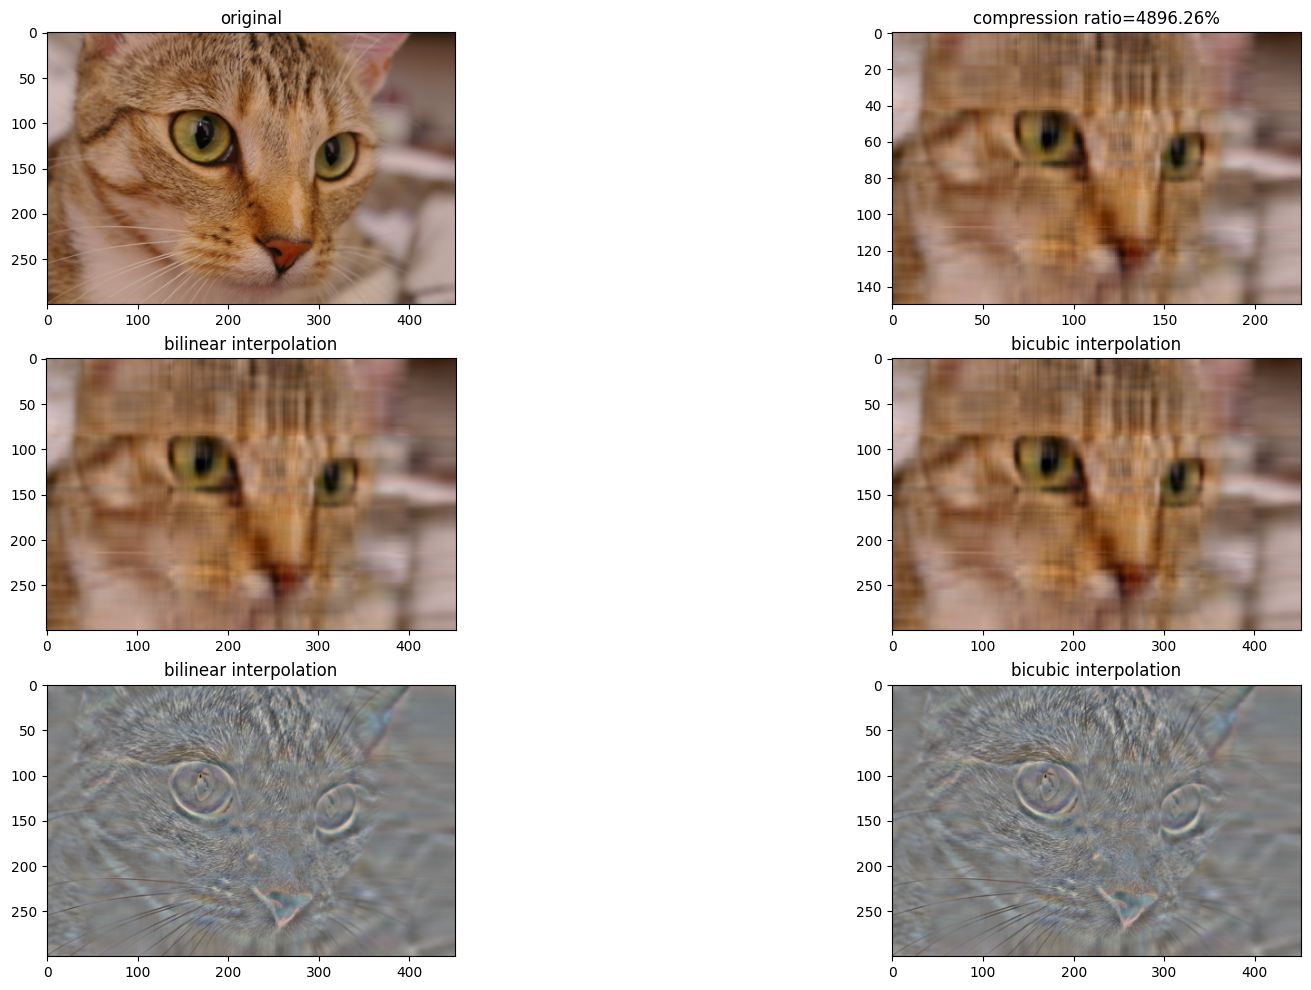

In [20]:
interact(show_reshaped_color_images,img_name=list_widget_color,k=color_slider_widget);

In [21]:
list_widget_color_evalues = widgets.Dropdown(options=list(color_images.keys()))

def plot_graphs_color(img_name):

  image = color_images[img_name]
  original = image.shape
  reshaped = image.reshape((original[0],original[1]*3))

  _,sigma,_ = svd(reshaped, full_matrices=False)

  plt.figure(1)
  plt.semilogy(np.diag(sigma))
  plt.title('Valores singulares')
  plt.show()

  plt.figure(2)
  plt.plot(np.cumsum(np.diag(sigma))/np.sum(np.diag(sigma)))
  plt.title('Soma cumulativa dos valores singulares')
  plt.show(block=False)

def update_evalues_color(*args):
  img_name=list_widget_color_evalues.value
  plot_graphs_color(img_name)

list_widget_color.observe(update_evalues_color,'value')

In [22]:
interact(plot_graphs_color,img_name=list_widget_color_evalues);

interactive(children=(Dropdown(description='img_name', options=('cat', 'astro', 'coffee'), value='cat'), Outpu…

#Plot interativo para imagens em escala de cinza

In [23]:
def show_reshaped_gray_images(img_name,k):
    """
     compress and display the reconstructed gray image using the reshape method
    """
    original_image = gray_images[img_name]
    original_shape = original_image.shape
    image = reduce_image(original_image)
    original = image.shape
    reshaped = image.reshape((original[0],original[1]))

    reconst,_ = reduced_svd(reshaped,k)
    # reconst = reconst.reshape(original)
    compression_ratio =100.0*(original_shape[0]*original_shape[1])/(k*(original[0] + original[1])+k)

    fig = plt.figure(figsize=(20, 12))

    fig.add_subplot(3, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("original")

    fig.add_subplot(3, 2, 2)
    plt.imshow(reconst, cmap='gray')
    plt.title("compression ratio={:.2f}".format(compression_ratio)+"%")

    fig.add_subplot(3, 2, 3)
    bl_interp = interpolate_bilinear_2D(reconst, 2)
    plt.imshow(bl_interp, cmap='gray')
    plt.title("bilinear interpolation")

    fig.add_subplot(3, 2, 4)
    bc_interp = bicubic_interp_2D(reconst, 2)
    plt.imshow(bc_interp, cmap='gray')
    plt.title("bicubic interpolation")

    fig.add_subplot(3, 2, 5)
    err_bl_interp = bl_interp[:original_shape[0],:original_shape[1]]
    plt.imshow(.5-(original_image-err_bl_interp), cmap='gray')
    plt.title("bilinear interpolation")

    fig.add_subplot(3, 2, 6)
    err_bc_interp = bc_interp[:original_shape[0],:original_shape[1]]
    plt.imshow(.5-(original_image-err_bc_interp), cmap='gray')
    plt.title("bicubic interpolation")

In [24]:
def compute_k_max_gray(img_name):

  image = gray_images[img_name]
  _, sigma, _ = svd(image, full_matrices=False)
  return len(sigma)

In [25]:
list_widget_gray = widgets.Dropdown(options=list(gray_images.keys()))
gray_slider_widget = widgets.IntSlider(min=10,max=compute_k_max_gray('coin'), step=1)

def update_k_max_gray(*args):
  img_name=list_widget_color.value
  gray_slider_widget.max = compute_k_max_gray(img_name)

list_widget_color.observe(update_k_max_gray,'value')

In [26]:
def on_slider_change(change):
  clear_output(wait=True)
  show_reshaped_gray_images(change['new'])

gray_slider_widget.observe(on_slider_change, names='values')

interactive(children=(Dropdown(description='img_name', options=('camera', 'coin', 'clock'), value='camera'), I…

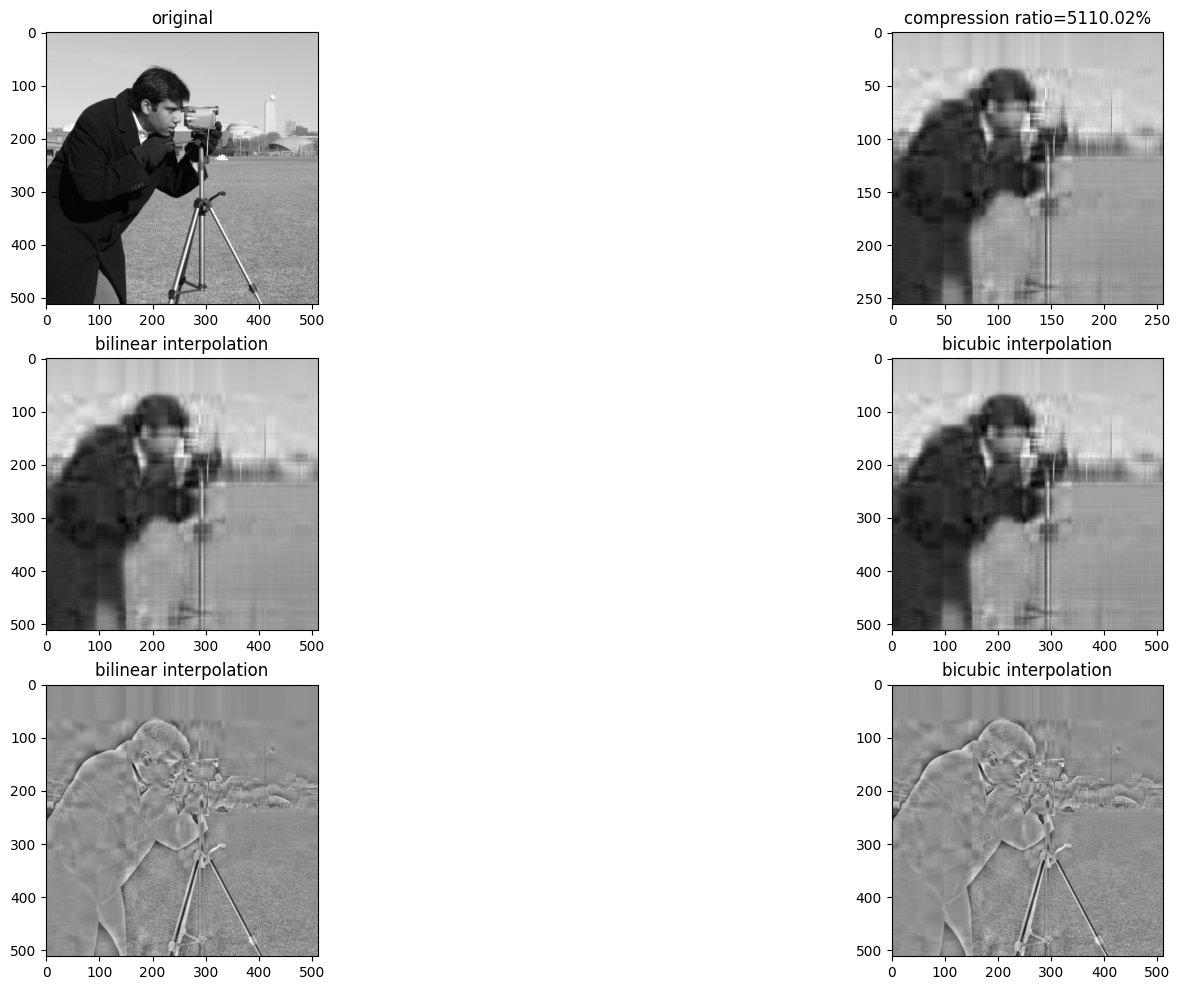

In [27]:
interact(show_reshaped_gray_images,img_name=list_widget_gray,k=gray_slider_widget);

In [28]:
list_widget_gray_evalues = widgets.Dropdown(options=list(gray_images.keys()))

def plot_graphs_gray(img_name):

  image = gray_images[img_name]
  original = image.shape
  reshaped = image.reshape((original[0],original[1]))

  _,sigma,_ = svd(reshaped, full_matrices=False)

  plt.figure(1)
  plt.semilogy(np.diag(sigma))
  plt.title('Valores singulares')
  plt.show()

  plt.figure(2)
  plt.plot(np.cumsum(np.diag(sigma))/np.sum(np.diag(sigma)))
  plt.title('Soma cumulativa dos valores singulares')
  plt.show(block=False)

def update_evalues_gray(*args):
  img_name=list_widget_gray_evalues.value
  plot_graphs_gray(img_name)

list_widget_color.observe(update_evalues_gray,'value')

In [29]:
interact(plot_graphs_gray,img_name=list_widget_gray_evalues);

interactive(children=(Dropdown(description='img_name', options=('camera', 'coin', 'clock'), value='camera'), O…